In [1]:
%load_ext autoreload

In [2]:
import os
import math
import random
import statistics

import einops

import numpy as np

import torch
from torch import nn
from torch import Tensor

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

from sklearn import datasets as sk_datasets

In [3]:
%autoreload 2
import utils
from model import SimpleNet, ModelOutput
from samplers import VPSDE, VESDE, DDPM, SBTrainer
from datasets_2d import registry, DatasetSampler

In [4]:
def seed_everython(seed=3407):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everython(3407)

In [5]:
def extract_into_tensor(tensor, shape):
    num_expand_dims = len(shape) - 1
    return tensor.view([-1] + [1 for _ in range(num_expand_dims)])


def rotate_mean(mean, angle=torch.pi / 4):
    cos = math.cos(angle)
    sin = math.sin(angle)
    R = torch.tensor([
        [cos, -sin],
        [sin,  cos]
    ])
    return (R @ mean.T).T


def scatter(tensor):
    plt.scatter(tensor[:, 0], tensor[:, 1])
    

def plot_trajectory(trajectory, timesteps = None, indices: None | list = None):
    if indices is not None:
        trajectory = [trajectory[i] for i in indices]
        if timesteps is not None:
            timesteps = [timesteps[i] for i in indices]

    figure, axes  = plt.subplots(1, len(trajectory), figsize=(4 * len(trajectory), 4))
    for i, sample in enumerate(trajectory):
        if timesteps is not None:
            if type(timesteps[i]) == str:
                title = f'{timesteps[i]}' 
            else:
                title = f'timestep: {round(timesteps[i], 4)}'
        else:
            title = f'iter {i}'
        
        axes[i].set_title(title)
        axes[i].scatter(sample[:, 0], sample[:, 1]) 
                    #  c='r' if type(timesteps[i]) == str else 'b')
        axes[i].set_xlim(-1.5, 1.5)
        axes[i].set_ylim(-1.5, 1.5)
    plt.show()
    return figure

# Data

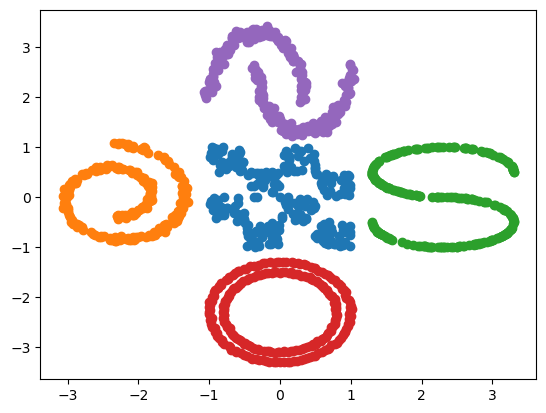

In [6]:
scatter(registry['checkboard'](256))
scatter(registry['swiss_roll'](256, noise=0.3, shift=torch.tensor([[-2.3, 0]])))
scatter(registry['s_curve'](256, noise=0.0, shift=torch.tensor([[2.3, 0]])))
scatter(registry['two_circles'](256, noise=0.01, shift=torch.tensor([[0, -2.3]])))
scatter(registry['two_moons'](256, noise=0.05, shift=torch.tensor([[0, 2.3]])))

plt.show()

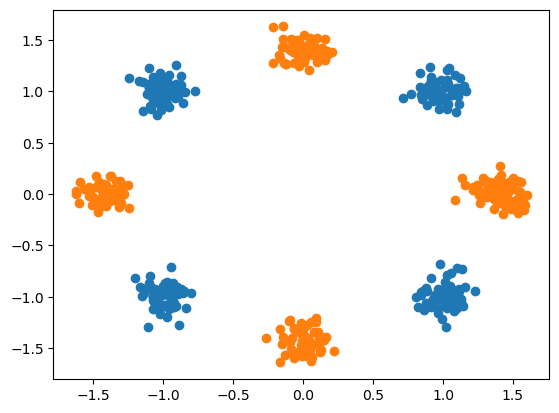

In [7]:
mean = torch.tensor([[-1, 1], [1, 1], [1, -1], [-1, -1]]) * 1.0
sigmas = torch.ones_like(mean) * 0.1

sampler = DatasetSampler(
    p_0='mix_of_gaussians', p_0_args=[mean, sigmas],
    p_1='mix_of_gaussians', p_1_args=[rotate_mean(mean), sigmas],
)

x_0, x_1 = sampler.sample(256)

scatter(x_0)
scatter(x_1)

# DDPM

In [ ]:
def linear_schedule(n_steps):
    scale = 1000 / n_steps
    start, end = scale * 0.0001, scale * 0.02
    return torch.linspace(start, end, n_steps)


model = SimpleNet(64, 64)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
ddpm = DDPM(linear_schedule(100), 100)

loss_history = []
for i in trange(5000):
    x_0, _ = sampler.sample(256)
    t = torch.randint(0, ddpm.n_steps, (x_0.size(0),))
    loss = ddpm.train_loss(model, x_0, t)
    
    optim.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()
    
    loss_history.append(loss.item())    

  0%|          | 0/5000 [00:00<?, ?it/s]

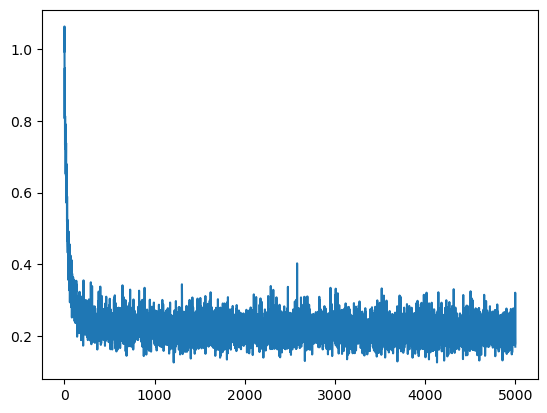

In [ ]:
plt.plot(loss_history)
plt.show()

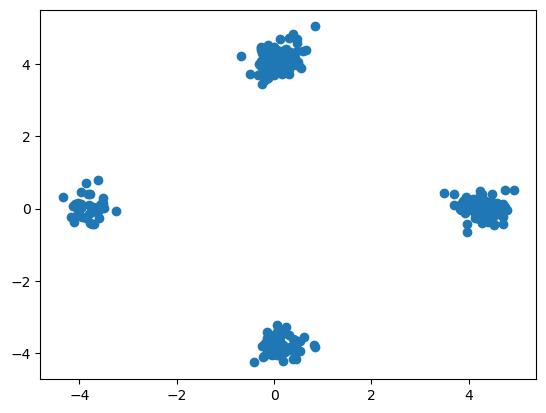

In [ ]:
ddpm = DDPM(linear_schedule(100), 100)
x_t = ddpm.sample(model, (256, 2), sample_with='ansesterial')

scatter(x_t)

# VP SDE

#### draw noising paths

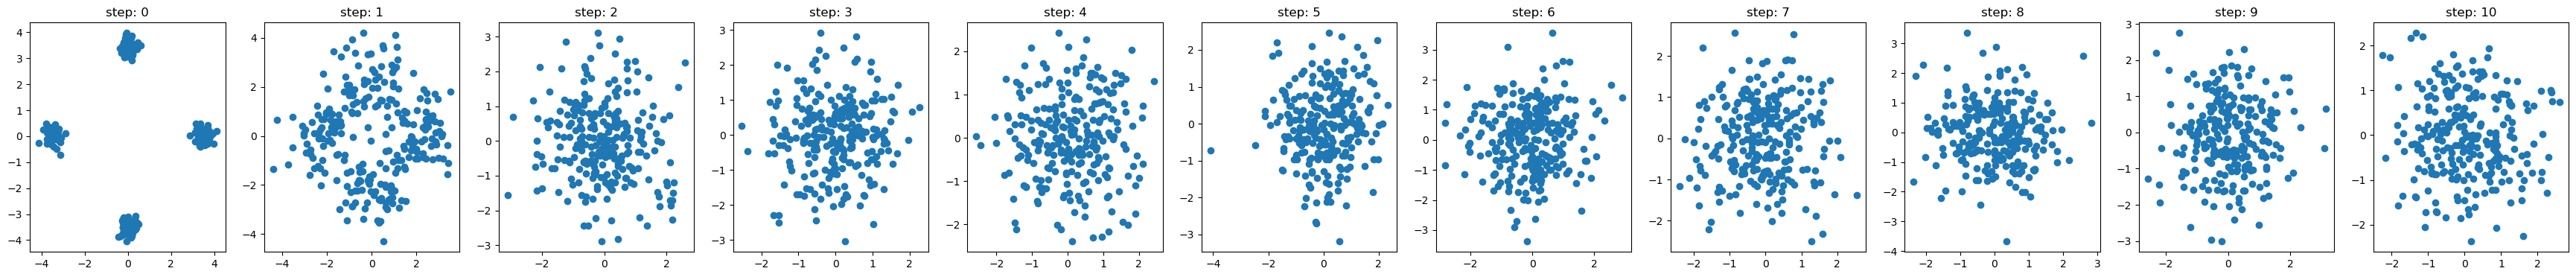

In [ ]:
vp = VPSDE(0.1, 20.0, n_steps=100)
x_0, x_1 = sampler.sample(256)

trajectory = [x_0]
for t in range(vp.n_steps // 10 - 1, vp.n_steps, vp.n_steps // 10):
    t = torch.ones(256) * t / vp.n_steps
    x_t = vp.sample_x_t_from_x_0(x_0, t)
    trajectory.append(x_t)

plot_trajectory(trajectory)

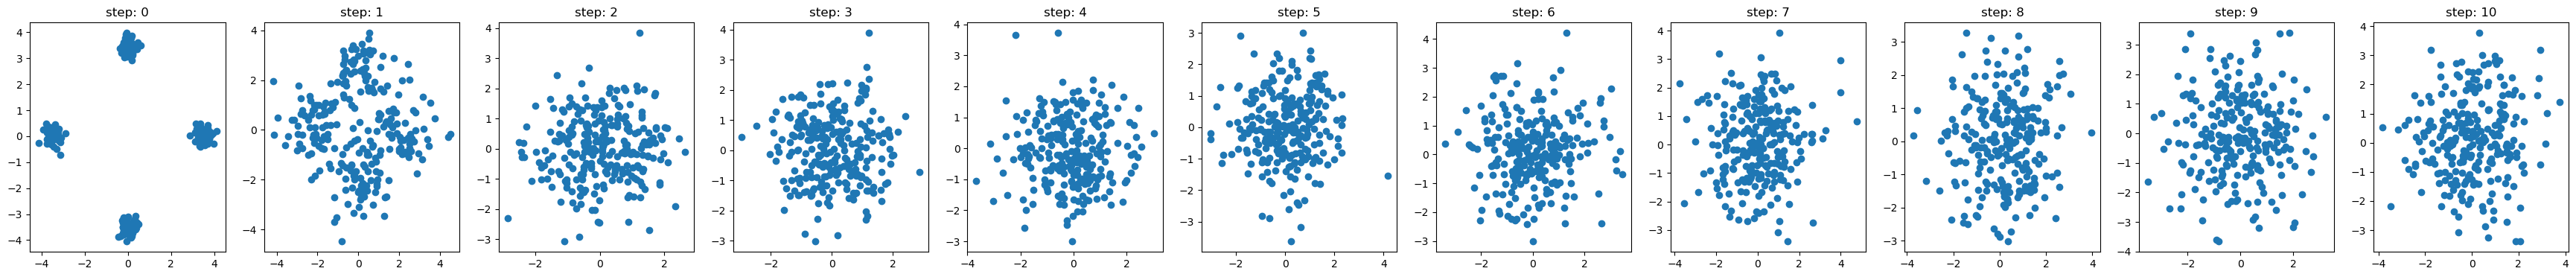

In [ ]:
x_t = x_0.clone()

trajectory = [x_0]
for i in range(vp.n_steps):
    t = torch.ones(256) * i / vp.n_steps
    x_t = x_t + vp.make_fwd_step(x_t, t)
    
    if (i + 1) % (vp.n_steps // 10) == 0:
        trajectory.append(x_t)

plot_trajectory(trajectory)

#### train

In [ ]:
B_SIZE = 256
N_STEPS = 5_000

vp = VPSDE(0.1, 20.0, n_steps=100)
score_model = SimpleNet(64, 64)
optim = torch.optim.AdamW(score_model.parameters(), lr=1e-3)

loss_history = []
for step in trange(N_STEPS):
    optim.zero_grad(set_to_none=True)
    
    x_0, _ = sampler.sample(B_SIZE)
    t = torch.rand(x_0.size(0))
    
    loss = vp.compute_loss(score_model, x_0, t, learn_score=False)
    
    loss.backward()
    optim.step()
    
    loss_history.append(loss.item())

  0%|          | 0/5000 [00:00<?, ?it/s]

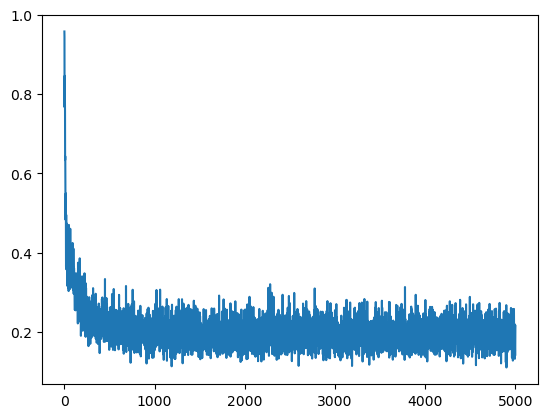

In [ ]:
plt.plot(loss_history)
plt.show()

In [ ]:
vp = VPSDE(0.1, 20.0, n_steps=100)
x_t = torch.randn(256, 2)
trajectory = [x_t]

for t in range(vp.n_steps - 1, -1, -1):
    t = torch.maximum(torch.ones(256) * t, torch.as_tensor(1e-3)) / vp.n_steps
    score = vp.score_from_noise(score_model, x_t, t)
    x_t = x_t + vp.make_bwd_step(score, x_t, t, ode_flow=False)
    
    trajectory.append(x_t)


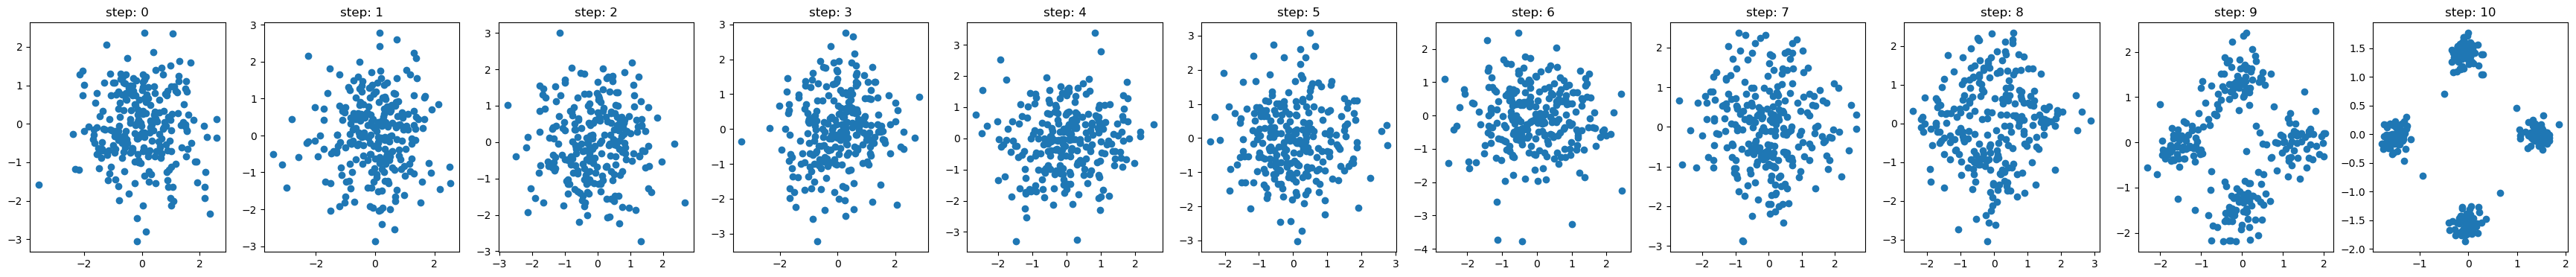

In [ ]:
plot_trajectory([trajectory[i] for i in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100 - 1]])
# plot_trajectory(trajectory)

# VESDE & SMLD

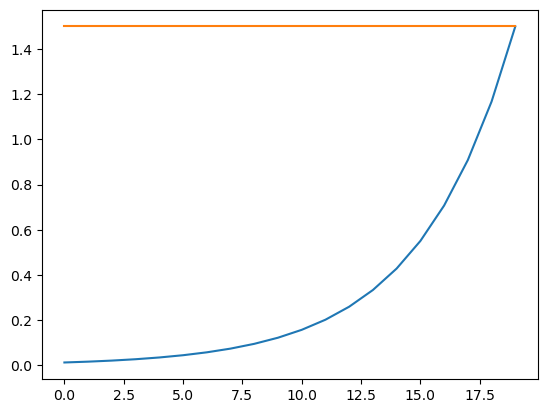

In [ ]:
sigma_min = 0.01
sigma_max = 1.5
n_steps = 20

step = (sigma_max / sigma_min) ** (1 / n_steps)
sigma_schedule = [sigma_min * step**(i+1) for i in range(n_steps)]
plt.plot(sigma_schedule)
plt.plot([sigma_max] * n_steps)
plt.show()

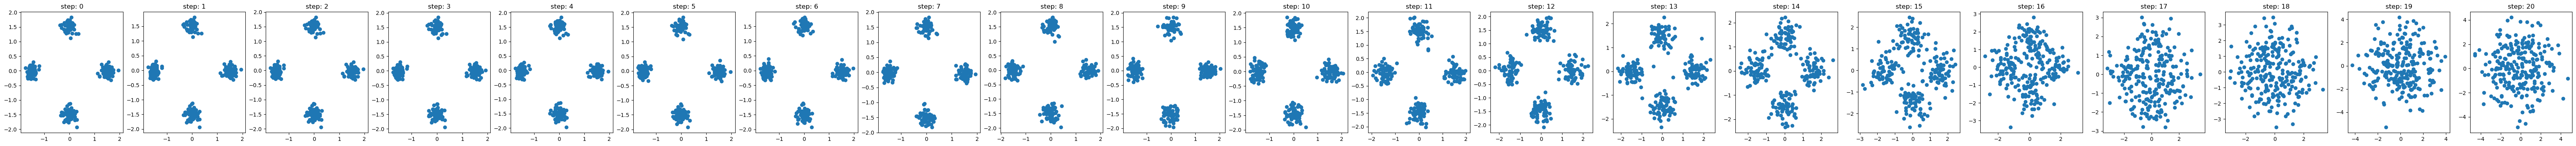

In [ ]:
x_0, _ = sampler.sample(256)

trajectory = [x_0]
for sigma in sigma_schedule:
    trajectory.append(x_0 + torch.randn_like(x_0) * sigma)

plot_trajectory(trajectory)

In [ ]:
sigma_min = 0.01
sigma_max = 1.5
n_steps = 20

sigma_coeff = (sigma_max / sigma_min) ** (1 / n_steps) 

In [341]:
score = SimpleNet(64, 64)
optim = torch.optim.AdamW(score.parameters(), lr=1e-3)

loss_history = []
for step in trange(N_STEPS):
    optim.zero_grad(set_to_none=True)
    
    x_0, _ = sampler.sample(256)
    steps = torch.randint(1, n_steps + 1, (x_0.size(0),))
    sigma = extract_into_tensor(sigma_min * (sigma_coeff) ** (steps), x_0.shape)
    
    x_sigma = x_0 + sigma * torch.randn_like(x_0)
    pred_score = score(x_sigma, sigma.squeeze(-1))
    true_score = - (x_sigma - x_0) / sigma**2
    loss = nn.functional.mse_loss(pred_score, true_score)
    
    loss.backward()
    optim.step()
    
    loss_history.append(loss.item())

NameError: name 'N_STEPS' is not defined

# SB via IPF

In [ ]:
def make_euler_maruyama_step(x, t, dt, f = None, t_max=0.2, no_grad: bool = True):        
    log_var = torch.as_tensor(2.0 * dt).log()
    z = torch.randn_like(x)

    with torch.set_grad_enabled(not no_grad):
        output = f(x, t)
    
    if output.contains('log_var'):
        log_var = log_var + output.log_var

    mean = x + output.drift * dt
    return mean + log_var.exp().sqrt() * z


def log_normal_density(x, mean, log_var):
    log_2pi = math.log(2 * torch.pi)
    loss = - 0.5 * (log_2pi + log_var + torch.exp(- log_var) * (x - mean).pow(2))
    return loss.sum(dim=-1)


def compute_fwd_log_likelihood_loss(model, x_t, x_t_m_dt, t, dt):
    r"""
        Compute log p( x_{t} | x_{t-dt} ) with the following logic:
        DRIFT, VAR = model( x_{t-dt}, t-dt )
        log p( x_{t} | x_{t-dt} ) = log N( x_{t} | x_{t-dt} + DRIFT * dt, VAR )
    """
    log_var = torch.as_tensor(2.0 * gamma).log()
    
    output = model(x_t_m_dt, t - dt)
    mean_pred = x_t_m_dt + dt * output.drift

    if output.contains('log_var'):
        log_var = output.log_var + log_var
    
    loss = - log_normal_density(x_t, mean_pred, log_var)
    return loss.mean()


def compute_bwd_log_likelihood_loss(model, x_t, x_t_m_dt, t, dt):
    r"""
        Compute log p( x_{t-dt} | x_{t} ) with the following logic:
        DRIFT, VAR = model( x_{t}, t )
        log p( x_{t-dt} | x_{t} ) = log N( x_{t-dt} | x_{t} + DRIFT * dt, VAR )
    """
    log_var = torch.tensor(2.0 * dt).log()

    output = model(x_t, t)
    mean_pred = x_t + dt * output.drift

    if output.contains('log_var'):
        log_var = output.log_var + log_var

    loss = - log_normal_density(x_t_m_dt, mean_pred, log_var)
    return loss.mean()


def ref_process(x, t):
    return ModelOutput(drift=-gamma * alpha * x)


alpha = 4
gamma = 0.0006
t_max = 0.012
n_steps = 20

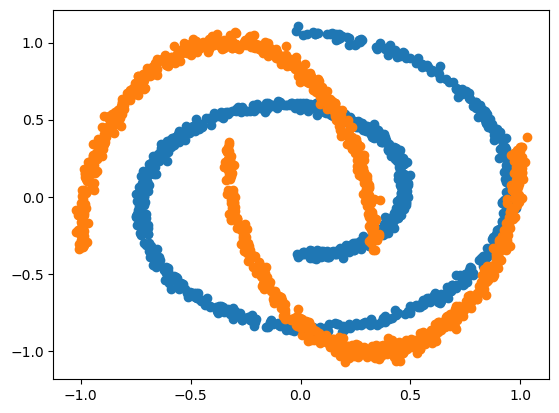

In [10]:
mean = torch.tensor([[-1, 1], [1, 1], [1, -1], [-1, -1]]) * 1.0
sigma = torch.ones_like(mean) * 0.1

sampler = DatasetSampler(
    # p_0='mix_of_gaussians', p_0_args=[mean, sigmas],
    p_0='swiss_roll', p_0_args=[None, 0.2],
    p_1='two_moons', p_1_args=[None, 0.02],
    # p_1='checkboard', p_1_args=[None],
)
x_0, x_1 = sampler.sample(1024)
scatter(x_0)
scatter(x_1)
plt.show()

#### Train Forward Model (P0 --> P1) via mean matching

##### Check reference process

Reference process


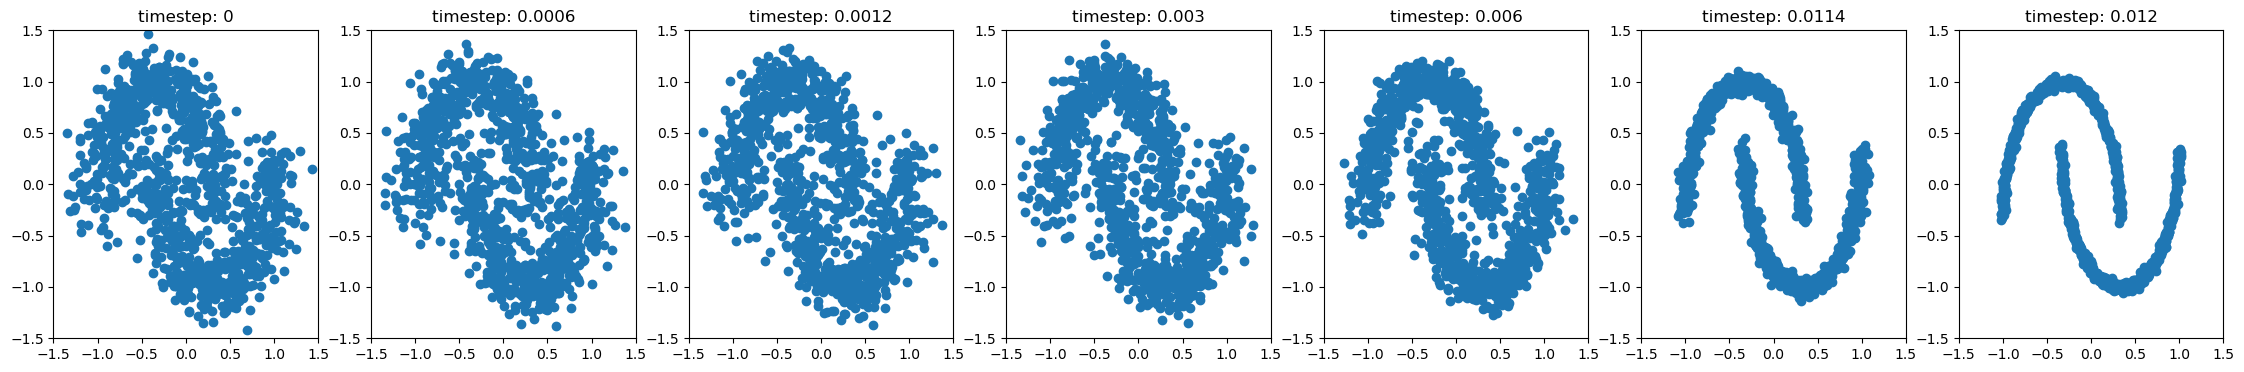

In [12]:
x_0,  x_1 = sampler.sample(1024)

reference_trajectory = [x_1]
timesteps = []

for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
    t = torch.ones(x_1.size(0)) * t_step
    
    x_next = make_euler_maruyama_step(reference_trajectory[-1], t, gamma, f=ref_process)
    
    reference_trajectory.append(x_next)
    timesteps.append(t_step.item())

timesteps.append(0)

print('Reference process')
_ = plot_trajectory(reference_trajectory[::-1], timesteps[::-1], indices=[0, 1, 2, 5, 10, -2, -1])

##### Train forward model

In [27]:
N_MAX_ITER = 6_000
PREDICT_LOGVAR = True

fwd_model = SimpleNet(64, 64, n_main_body_layers=3, predict_log_var=PREDICT_LOGVAR)
fwd_optim = torch.optim.Adam(fwd_model.parameters(), lr=7e-4)

ema_loss = utils.EMALoss(alpha=0.09)
var_crit = utils.VarCriterion(ema_loss.ema, threshold=1e-6, max_iter=N_MAX_ITER, measure_size=500)

with tqdm(total=N_MAX_ITER, leave=False) as pbar:
    while var_crit.check():
        traj_loss = 0
        fwd_optim.zero_grad(set_to_none=True)
        
        _, x_t = sampler.sample(512)
        for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
            t = torch.ones(x_t.size(0)) * t_step

            x_t_m_dt = make_euler_maruyama_step(x_t, t, gamma, f=ref_process, no_grad=True)      
            loss = compute_fwd_log_likelihood_loss(fwd_model, x_t, x_t_m_dt, t, gamma)   
            
            loss.backward()
            traj_loss += loss.item()

            x_t = x_t_m_dt

        ema_loss.update(traj_loss / n_steps)
        fwd_optim.step()
        
        pbar.update(1)

    pbar.close()

  0%|          | 0/6000 [00:00<?, ?it/s]

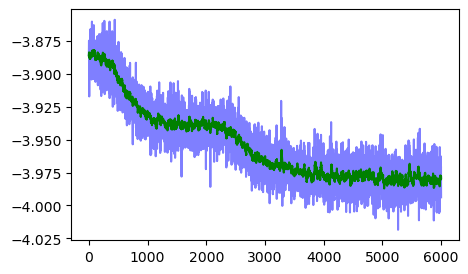

In [28]:
plt.figure(figsize=(5, 3))
plt.plot(ema_loss.loss, alpha=0.5, c='b')
plt.plot(ema_loss.ema, c='g')
plt.show()

Reference process


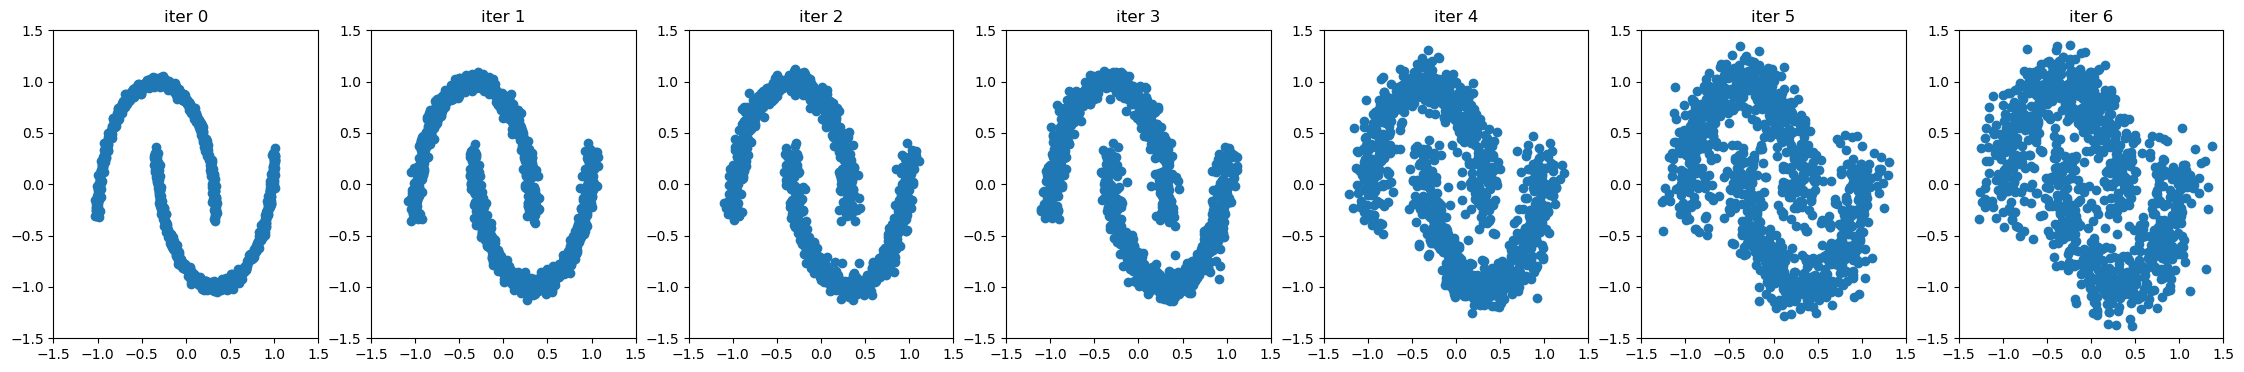

Learned trajectory for B


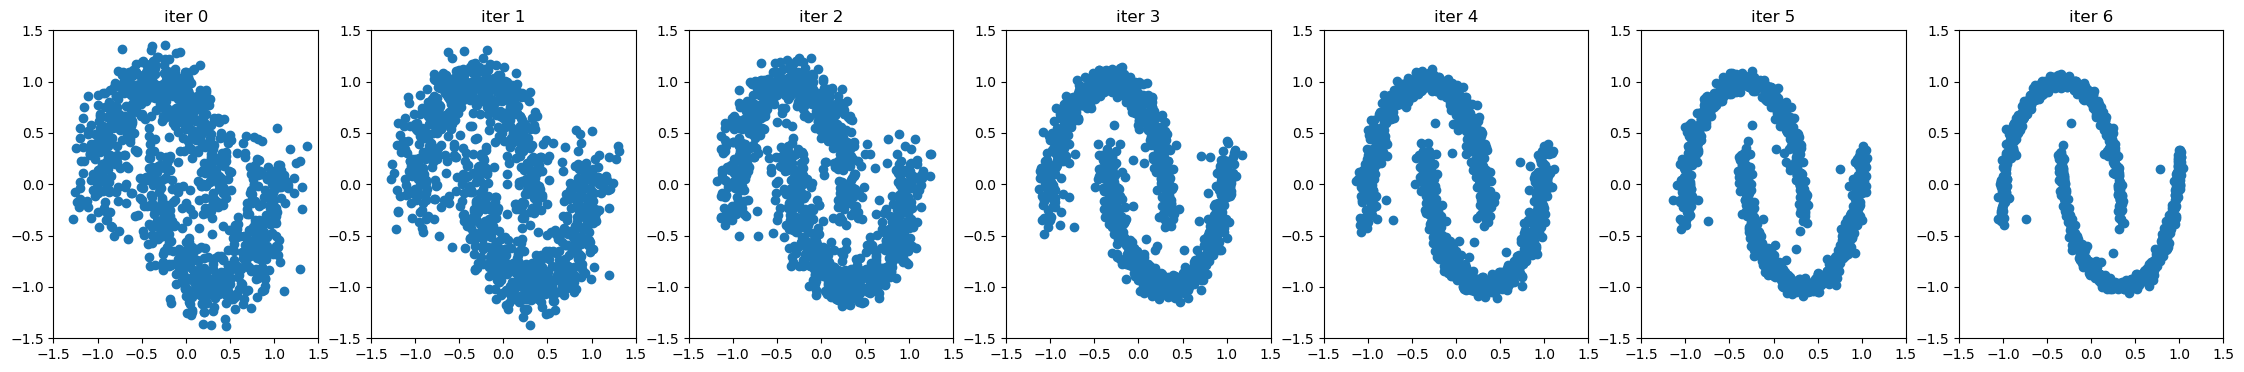

In [29]:
_, x_1 = sampler.sample(1024)

reference_trajectory = [x_1]
for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
    t = torch.ones(x_1.size(0)) * t_step
    x_next = make_euler_maruyama_step(reference_trajectory[-1], t, gamma, f=ref_process, no_grad=True)
    reference_trajectory.append(x_next)

print('Reference process')
f = plot_trajectory(reference_trajectory, indices=[0, 1, 2, 3, 10, 15, -1])


learned_trajectory = [reference_trajectory[-1]]
for t_step in torch.linspace(0, t_max - gamma, n_steps):
    t = torch.ones(x_1.size(0)) * t_step
    x_next = make_euler_maruyama_step(learned_trajectory[-1], t, gamma, f=fwd_model, no_grad=True)
    learned_trajectory.append(x_next)

print('Learned trajectory for B')
f = plot_trajectory(learned_trajectory , indices=[0, 5, 10, -4, -3, -2, -1])

#### Train Backward Model (P1 --> P0) via mean matching

##### Check reference process

Reference process


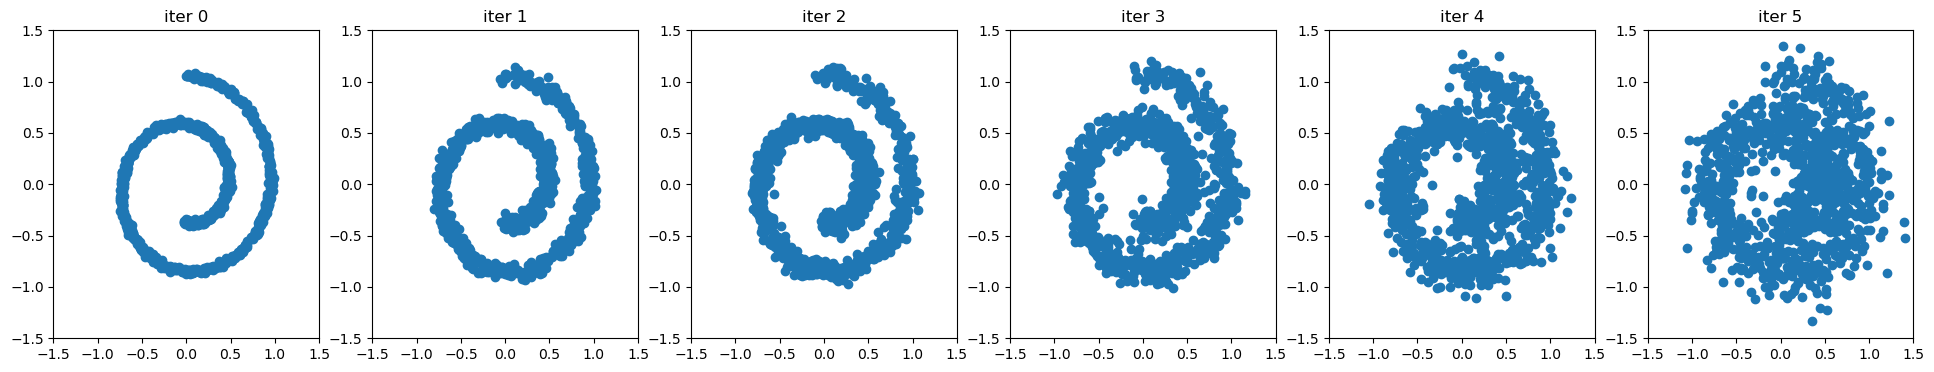

In [ ]:
x_0, _ = sampler.sample(1024)

reference_trajectory = [x_0]
for t_step in torch.linspace(0, t_max - gamma, n_steps):
    t = torch.ones(x_0.size(0)) * t_step
    x_next = make_euler_maruyama_step(reference_trajectory[-1], t, gamma, f=ref_process)
    reference_trajectory.append(x_next)

print('Reference process')
_ = plot_trajectory(reference_trajectory, indices=[0, 1, 2, 5, 10, -1])

##### Train backward model

In [ ]:
N_MAX_ITER = 6_000
USE_MEAN_MATCHING = True

bwd_model = SimpleNet(64, 64, predict_log_var=True)
bwd_optim = torch.optim.Adam(bwd_model.parameters(), lr=7e-4)

ema_loss = utils.EMALoss()
var_crit = utils.VarCriterion(
    ema_loss.ema, threshold=1e-6, 
    max_iter=N_MAX_ITER, measure_size=500
)

with tqdm(total=N_MAX_ITER, leave=False) as pbar:
    while var_crit.check():
        traj_loss = 0
        bwd_optim.zero_grad(set_to_none=True)

        x_t_m_dt, _ = sampler.sample(512)
        for t_step in torch.linspace(gamma, t_max, n_steps):
            t = torch.ones(512) * t_step
            
            x_t = make_euler_maruyama_step(x_t_m_dt, t-gamma, gamma, f=ref_process)
            loss = compute_bwd_log_likelihood_loss(bwd_model, x_t, x_t_m_dt, t, gamma)
        
            loss.backward()
            traj_loss += loss.item()

            x_t_m_dt = x_t

        ema_loss.update(traj_loss / n_steps)
        bwd_optim.step()

        pbar.update(1)
    pbar.close()

  0%|          | 0/6000 [00:00<?, ?it/s]

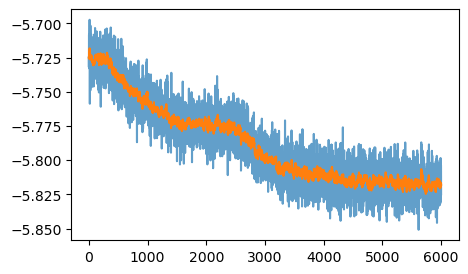

In [44]:
plt.figure(figsize=(5, 3))
plt.plot(ema_loss.loss, alpha=0.7)
plt.plot(ema_loss.ema)
plt.show()

Reference Trajectory


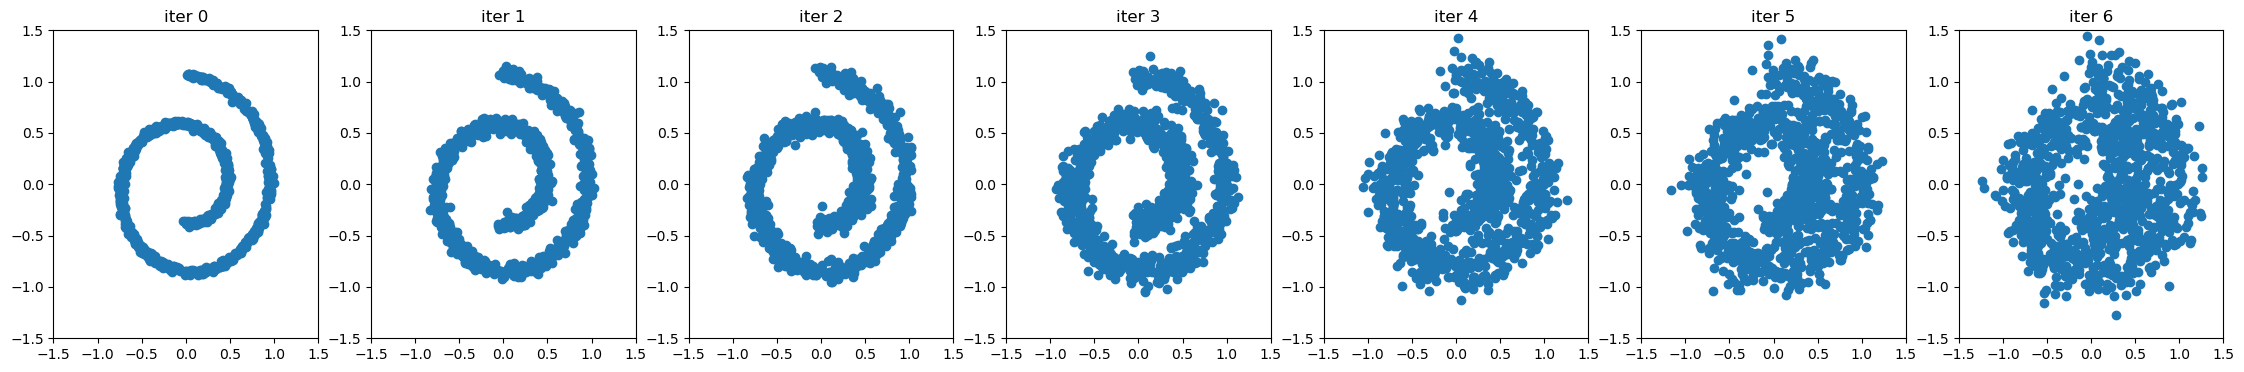

Learned Trajectory for F


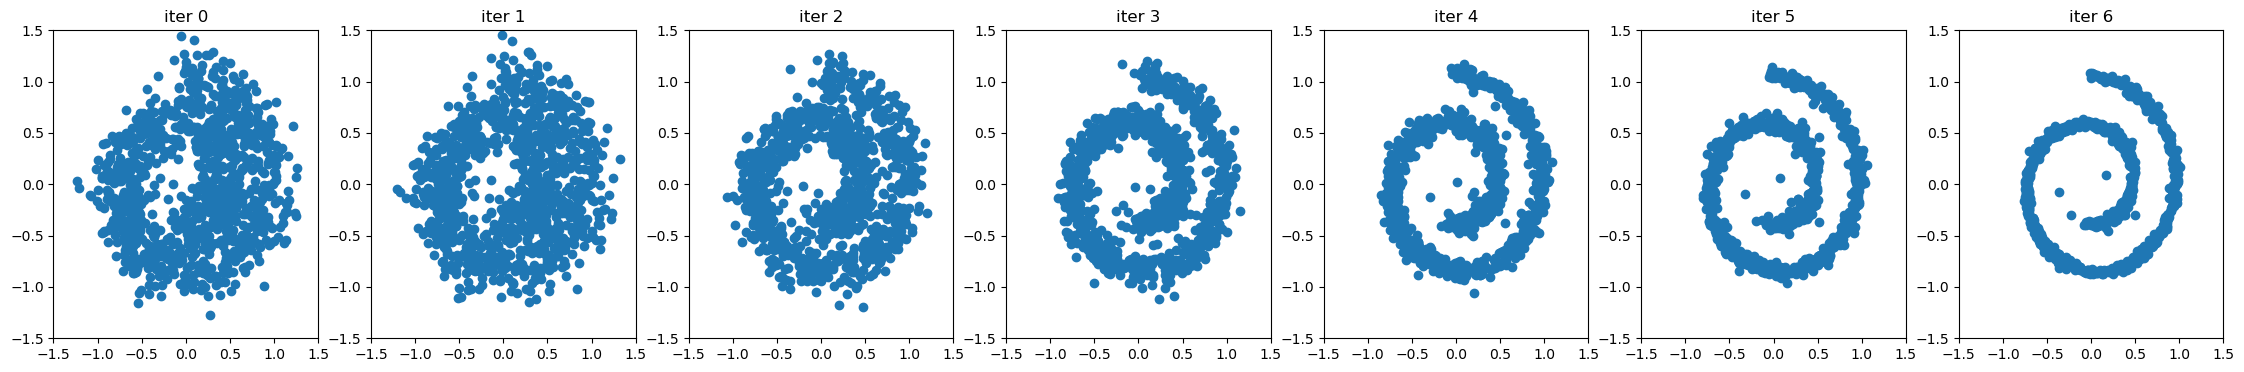

In [45]:
x_0, _  = sampler.sample(1024)

ref_trajectory = [x_0]
for t_step in torch.linspace(0, t_max - gamma, n_steps):
    t = torch.ones(1024) * t_step
    x_next = make_euler_maruyama_step(ref_trajectory[-1], t, gamma, f=ref_process)
    ref_trajectory.append(x_next, )

print('Reference Trajectory')
_ = plot_trajectory(ref_trajectory, indices=[0, 1, 2, 5, 10, 15 -2, -1])

learned_trajectory = [ref_trajectory[-1]]
with torch.no_grad():
    for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
        t = torch.ones(1024) * t_step
        x_next = make_euler_maruyama_step(learned_trajectory[-1], t, gamma, f=bwd_model)
        learned_trajectory.append(x_next)

print('Learned Trajectory for F')
_ = plot_trajectory(learned_trajectory, indices=[0, 1, 10, 15, -3, -2, -1])

#### Full SBM

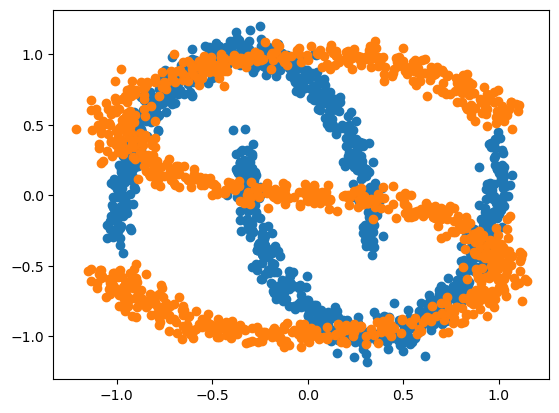

In [21]:
mean = torch.tensor([[-1, 1], [1, 1], [1, -1], [-1, -1]]) * 1.0
sigma = torch.ones_like(mean) * 0.1

sampler = DatasetSampler(
    # p_0='mix_of_gaussians', p_0_args=[mean, sigmas],
    p_0='two_moons', p_0_args=[None, 0.05],
    p_1='s_curve', p_1_args=[None, 0.09],
)
x_0, x_1 = sampler.sample(1024)
scatter(x_0)
scatter(x_1)
plt.show()

In [13]:

# sb_trainer = SBTrainer(
#     F=F_model, B=B_model,
#     sampler=sampler,
#     alpha=4.0,
#     gamma=0.0006,
#     batch_size=256,
#     threshold=5e-6,
#     num_sb_steps=20,
#     lr_forward=8e-4,
#     lr_backward=8e-4,
#     max_num_iters_per_step=MAX_CONVERGENCE_ITER,
# )
# sb_trainer.train()

In [ ]:
def ref_process(x, t):
    return ModelOutput(drift=-gamma * alpha * x)


alpha = 4
gamma = 0.0006
t_max = 0.0120
n_steps = 20

BATCH_SIZE = 256
NUM_SB_ITERATIONS = 20
MAX_CONVERGENCE_ITER = 6000

B_model = SimpleNet(64, 64, predict_log_var=True)
F_model = SimpleNet(64, 64, predict_log_var=True)

optim_B = torch.optim.Adam(B_model.parameters(), lr=8e-4)
optim_F = torch.optim.Adam(F_model.parameters(), lr=8e-4)

# Energy based SB

## Gaussian Energy

In [63]:
def gaussian_energy(x, means, sigmas, mode_weights=None):
    '''
        x: Tensor[B, Dim] - input 
        means: Tensor[NModes, Dim]
        sigmax: Tensor[NModes, Dim, Dim]
    '''
    if mode_weights is None:
        mode_weights = torch.ones(means.size(0)) / means.size(0)
        
    assert mode_weights.ndim == 1
    assert torch.allclose(mode_weights.sum(), torch.as_tensor(1.0))
    assert mode_weights.size(-1) == means.size(0)

    dim = x.size(-1)
    x = x.unsqueeze(1)
    means = means.unsqueeze(0)
    mode_weights = mode_weights.unsqueeze(0)
    diff = x - means

    det = torch.linalg.det(sigmas)
    inv_sigma = torch.linalg.inv(sigmas)
    
    unnormed_log_density = - 0.5 * torch.sum(
        einops.einsum(diff, inv_sigma, 'b m d, m d o -> b m o') * diff,
        dim=-1
    )

    norm_coeff = (2 * torch.pi)**(-dim / 2) * det**(- 0.5)
    norm_coeff = norm_coeff.unsqueeze(0)

    return -torch.log((norm_coeff * torch.exp(unnormed_log_density) * mode_weights).sum(-1))



class MixOfGaussians:
    def __init__(self, means, sigmas, mode_weights=None):
        self.means = means
        self.sigmas = sigmas
        
        if mode_weights is None:
            mode_weights = torch.ones(means.size(0)) / means.size(0)
        self.mode_weights = mode_weights

    def __call__(self, x):
        return gaussian_energy(x, self.means, self.sigmas, self.mode_weights) 


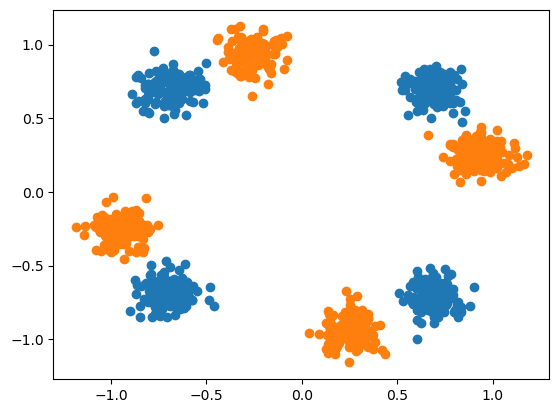

In [64]:
means = torch.tensor([[-1, 1],[-1, -1],[1, 1],[1, -1]]).float() * 0.7
sigmas = torch.ones_like(means) * 0.08

energy = MixOfGaussians(means, torch.diag_embed(sigmas))

sampler = DatasetSampler(
    p_0='mix_of_gaussians', p_0_args=[means, sigmas],
    p_1='mix_of_gaussians', p_1_args=[rotate_mean(means, torch.pi/ 3), sigmas],
)

x_0, x_1 = sampler.sample(512)

scatter(x_0)
scatter(x_1)

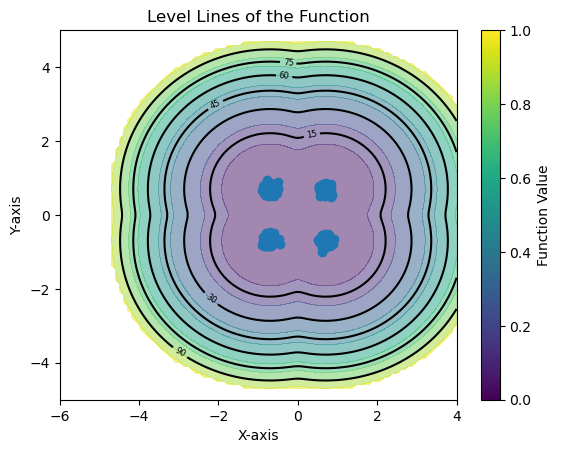

In [65]:
def my_function(batch):
    # Example: Sum of squares for demonstration
    return np.sum(batch**2, axis=-1)

# Step 1: Define the grid
x = np.linspace(-6, 4, 100)  # Define x-axis range
y = np.linspace(-5, 5, 100)  # Define y-axis range
X, Y = np.meshgrid(x, y)     # Create grid of points

# Step 2: Prepare the input for the function
grid_points = np.stack([X, Y], axis=-1)  # Shape: [100, 100, 2]

# Step 3: Evaluate the function on the grid
grid_points = torch.from_numpy(grid_points).reshape(-1, 2).float()
Z = energy(grid_points).numpy()  # Shape: [100, 100]
Z = Z.reshape(100, 100)

# Step 4: Plot contour lines
plt.figure()
contour = plt.contour(X, Y, Z, levels=7, colors='k')  # Draw contour lines
plt.clabel(contour, inline=True, fontsize=6)           # Add labels to contours
plt.contourf(X, Y, Z, levels=10, cmap='viridis', alpha=0.5)       # Filled contours for visualization
plt.scatter(x_0[:, 0], x_0[:, 1])
plt.colorbar(label='Function Value')                  # Add color bar
plt.title('Level Lines of the Function')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

## TB and PIS losses

In [169]:
def ref_process(x, t):
    return ModelOutput(drift=-gamma * alpha * x)


alpha = 4
gamma = 0.0006
t_max = 0.012
n_steps = 20

Reference process


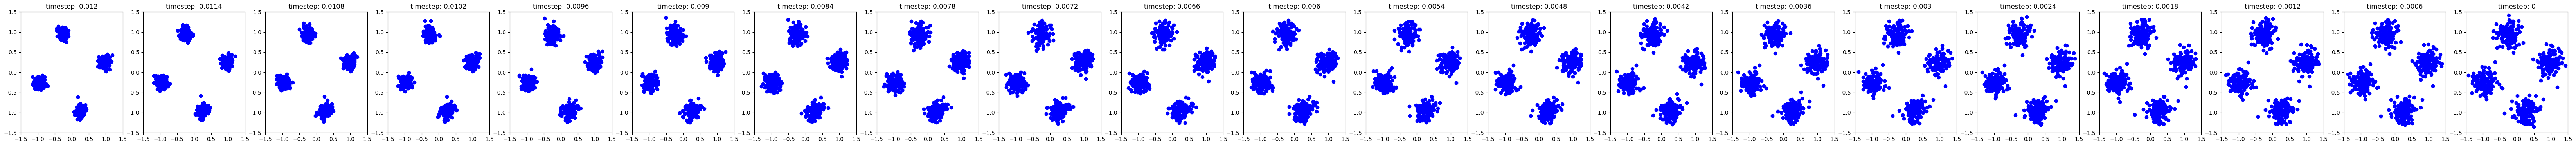

In [ ]:
_,  x_1 = sampler.sample(512)

reference_trajectory = [x_1]
timesteps = []
for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
    t = torch.ones(x_1.size(0)) * t_step
    x_next = make_euler_maruyama_step(reference_trajectory[-1], t, gamma, f=ref_process)
    reference_trajectory.append(x_next)
    timesteps.append(t_step.item())

timesteps.append(0)


print('Reference process')
_ = plot_trajectory(reference_trajectory, timesteps)

##### Configure data

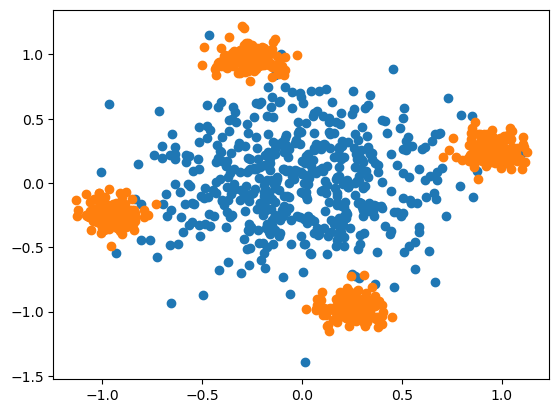

In [87]:
means = torch.tensor([[-1, 1],[-1, -1],[1, 1],[1, -1]]).float() * 0.7
sigmas = torch.ones_like(means) * 0.08

energy = MixOfGaussians(means, torch.diag_embed(sigmas))

sampler = DatasetSampler(
    p_0='mix_of_gaussians', p_0_args=[torch.tensor([0, 0]), torch.ones(1, 2) * 0.35],
    p_1='mix_of_gaussians', p_1_args=[rotate_mean(means, torch.pi/ 3), sigmas],
)

x_0, x_1 = sampler.sample(512)

scatter(x_0)
scatter(x_1)

Reference process


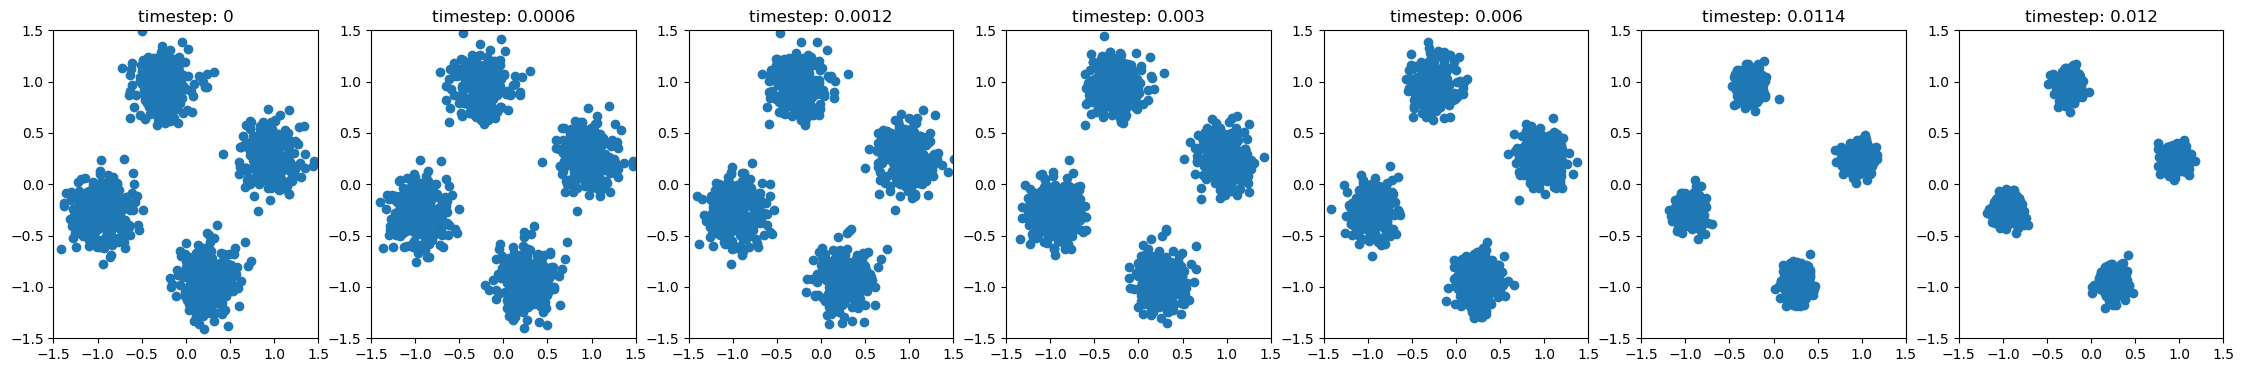

In [88]:
x_0,  x_1 = sampler.sample(1024)


def sample_trajectory(x_start, gamma, n_steps, t_max, reference):
    reference_trajectory = [x_start]

    for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
        t = torch.ones(x_start.size(0)) * t_step
        x_next = make_euler_maruyama_step(reference_trajectory[-1], t, gamma, f=reference)
        reference_trajectory.append(x_next)
    return reference_trajectory

reference_trajectory = sample_trajectory(x_1, gamma, n_steps, t_max, ref_process)

print('Reference process')
_ = plot_trajectory(reference_trajectory[::-1], timesteps[::-1], indices=[0, 1, 2, 5, 10, -2, -1])

##### Start training

In [134]:
alpha = 4
gamma = 0.0006
t_max = 0.012
n_steps = 20

def make_euler_maruyama_step(x, t, dt, f = None, no_grad: bool = True):        
    log_var = torch.as_tensor(2.0 * dt).log()
    z = torch.randn_like(x)

    with torch.set_grad_enabled(not no_grad):
        output = f(x, t)
    
    if output.contains('log_var'):
        log_var = log_var + output.log_var

    mean = x + output.drift * dt
    return mean + log_var.exp().sqrt() * z


def ref_process(x, t):
    return ModelOutput(drift=-gamma * alpha * x)


def log_normal_density(x, mean, log_var):
    return - 0.5 * (log_var + torch.exp(- log_var) * (mean - x).pow(2))


def compute_fwd_log_likelihood_loss(model, x_t, x_t_m_dt, t, dt):
    r"""
        Compute log p( x_{t} | x_{t-dt} ) with the following logic:
        DRIFT, VAR = model( x_{t-dt}, t-dt )
        log p( x_{t} | x_{t-dt} ) = log N( x_{t} | x_{t-dt} + DRIFT * dt, VAR )
    """
    log_var = torch.as_tensor(2.0 * gamma).log()
    
    output = model(x_t_m_dt, t - dt)
    mean_pred = x_t_m_dt + dt * output.drift

    if output.contains('log_var'):
        log_var = output.log_var + log_var
    
    loss = - log_normal_density(x_t, mean_pred, log_var)
    return loss.mean()


def compute_bwd_log_likelihood_loss(model, x_t, x_t_m_dt, t, dt):
    r"""
        Compute log p( x_{t-dt} | x_{t} ) with the following logic:
        DRIFT, VAR = model( x_{t}, t )
        log p( x_{t-dt} | x_{t} ) = log N( x_{t-dt} | x_{t} + DRIFT * dt, VAR )
    """
    log_var = torch.tensor(2.0 * dt).log()

    output = model(x_t, t)
    mean_pred = x_t + dt * output.drift

    if output.contains('log_var'):
        log_var = output.log_var + log_var

    loss = - log_normal_density(x_t_m_dt, mean_pred, log_var)
    return loss.mean()


def compute_fwd_tb_log_difference(fwd_model, bwd_model, energy, x_t_m_dt, dt, 
                                  t_max, num_t_steps, bwd_no_grad: bool = True):
    fwd_tl_sum, bwd_tl_sum = 0, 0
    
    for t_step in torch.linspace(dt, t_max, num_t_steps):
        t = torch.ones(x_t_m_dt.size(0)) * t_step

        x_t = make_euler_maruyama_step(x_t_m_dt, t - dt, dt, fwd_model, no_grad=False)

        # computing backward log likelihood
        with torch.set_grad_enabled(not bwd_no_grad):
            bwd_tl_sum = bwd_tl_sum + compute_bwd_log_likelihood_loss(
                bwd_model, x_t, x_t_m_dt, t, dt
            )

        # computing forward log likelihood
        fwd_tl_sum = fwd_tl_sum + compute_fwd_log_likelihood_loss(
            fwd_model, x_t, x_t_m_dt, t, dt
        )

        x_t_m_dt = x_t

    return fwd_tl_sum - bwd_tl_sum + energy(x_t_m_dt)

In [128]:
N_MAX_ITER = 6_000
PREDICT_LOGVAR = False

fwd_model = SimpleNet(64, 64, n_main_body_layers=3, predict_log_var=PREDICT_LOGVAR)
fwd_optim = torch.optim.Adam(fwd_model.parameters(), lr=7e-4)

ema_loss = utils.EMALoss(alpha=0.09)
for _ in trange(4_000):
    fwd_optim.zero_grad(set_to_none=True)
    
    _, x_1 = sampler.sample(512)
    x_t = sample_trajectory(x_1, gamma, n_steps, t_max, ref_process)[-1]

    diff_1 = compute_fwd_tb_log_difference(
        fwd_model, ref_process, energy, x_t, gamma, t_max, n_steps, True
    )

    diff_2 = compute_fwd_tb_log_difference(
        fwd_model, ref_process, energy, x_t, gamma, t_max, n_steps, True
    )

    loss = (diff_1 - diff_2).pow(2).mean()
    loss.backward()

    ema_loss.update(loss.item() / n_steps)
    fwd_optim.step()

  0%|          | 0/4000 [00:00<?, ?it/s]

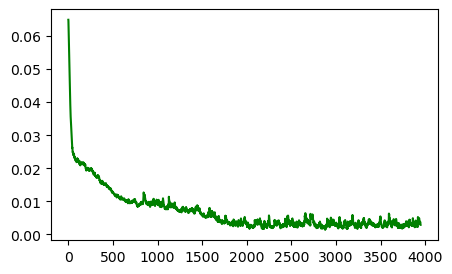

In [129]:
plt.figure(figsize=(5, 3))
# plt.plot(ema_loss.loss, alpha=0.5, c='b')
plt.plot(ema_loss.ema[50:], c='g')
plt.show()

In [131]:
len(reference_trajectory)

21

Reference process


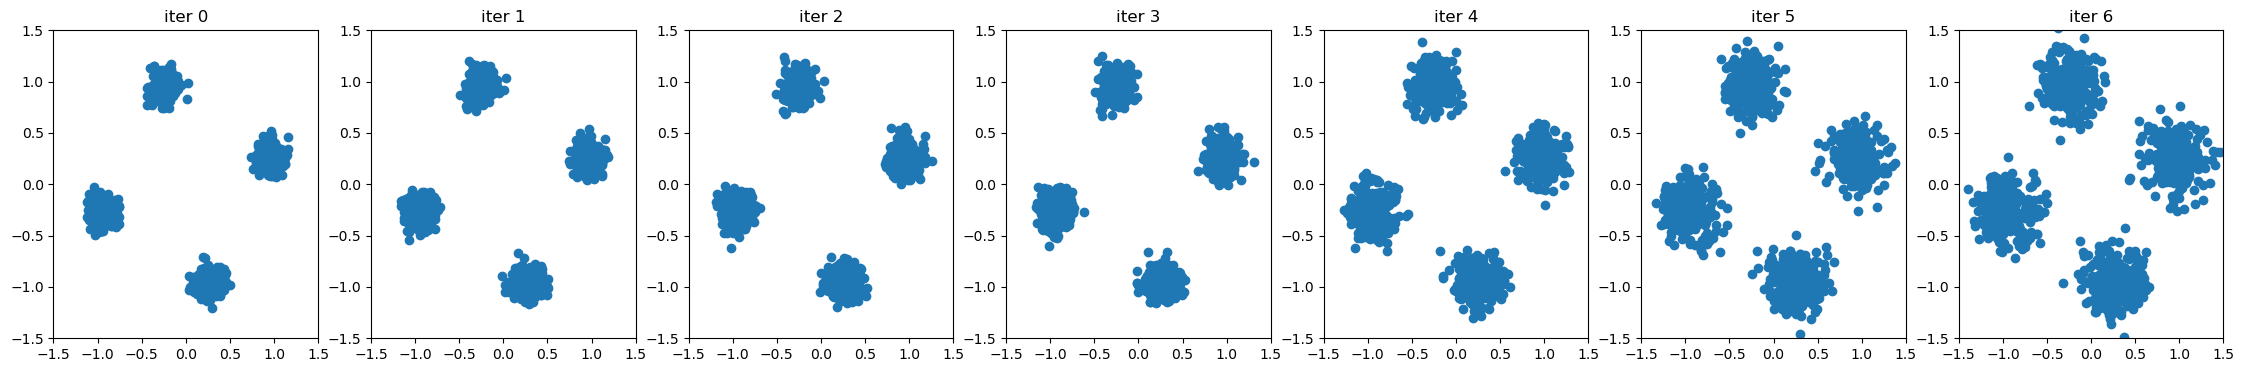

Learned trajectory for B


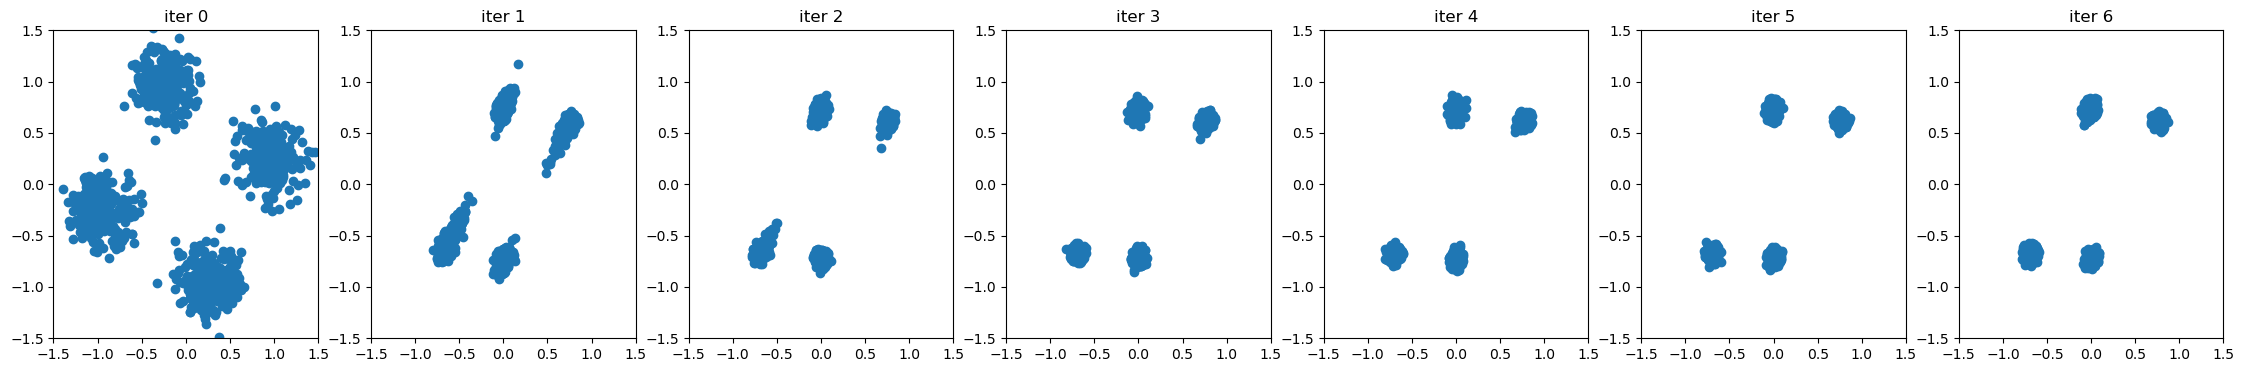

In [135]:
# _, x_1 = sampler.sample(1024)

# reference_trajectory = [x_1]
# for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
#     t = torch.ones(x_1.size(0)) * t_step
#     x_next = make_euler_maruyama_step(reference_trajectory[-1], t, gamma, f=ref_process, no_grad=True)
#     reference_trajectory.append(x_next)

print('Reference process')
f = plot_trajectory(reference_trajectory, indices=[0, 1, 2, 3, 10, 15, -1])


learned_trajectory = [reference_trajectory[-1]]
for t_step in torch.linspace(0, t_max - gamma, n_steps):
    t = torch.ones(learned_trajectory[-1].size(0)) * t_step
    x_next = make_euler_maruyama_step(learned_trajectory[-1], t, gamma, f=fwd_model, no_grad=True)
    learned_trajectory.append(x_next)

print('Learned trajectory for B')
f = plot_trajectory(learned_trajectory , indices=[0, 5, 10, -4, -3, -2, -1])